# Empirical distribution function

Given a sample $X_1, X_2, \dots, X_n$ generated from a distribution with CDF $F$, the empirical CDF is given as the CDF of the distribution that puts weight $1/n$ on each sample points. In other words,

$$ \hat{F}_n(x)=\frac{1}{n}\sum_{i=1}^n\mathbb{1}_{\{X_i\leq x\}}$$,

where $\mathbb{1}_{\{X_i\leq x\}}$ is one if $X_i\leq x$ and zero otherwise. Let us take a look at an example.

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In the file nerve.dat, there are 799 recorded waiting times between two successive pulses along a nerve fiber (Cox-Lewis, 1966). Let us first read in the data into a Pandas Series:

In [18]:
import os # os is a library that allows us to execute certain file and directory operations

cwd = os.getcwd()

#If on MAC, this will likely work
datadir = '/'.join(cwd.split('/')[0:-1]) + '/data/'
#If on window's machine, explicitly put in data dir
#datadir = 

table = pd.read_table(datadir + 'nerve.dat', sep = '\t', header=None)

# A little processing:
nerve_firings = pd.Series()

for i in range(6):
    nerve_firings = nerve_firings.append(table[i].dropna(axis = 0), ignore_index = True)

Let us take a look at the summary statistics first to see if we indeed have all data:

In [19]:
nerve_firings.describe()

count    799.000000
mean       0.218573
std        0.209189
min        0.010000
25%        0.070000
50%        0.150000
75%        0.300000
max        1.380000
dtype: float64

Now we want to plot the empirical CDF. One way to do it is, to make a cumulative histogram of the data:

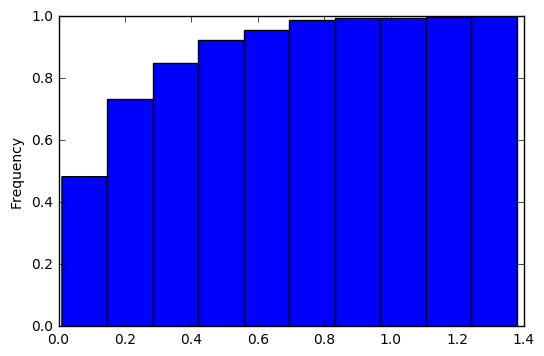

In [24]:
fig, axes = plt.subplots()

nerve_firings.plot(kind = 'hist', normed = True, cumulative = True)
plt.show()

However, this is a little ugly. Moreover, the even bins do not capture the structure of the data. Instead, we can

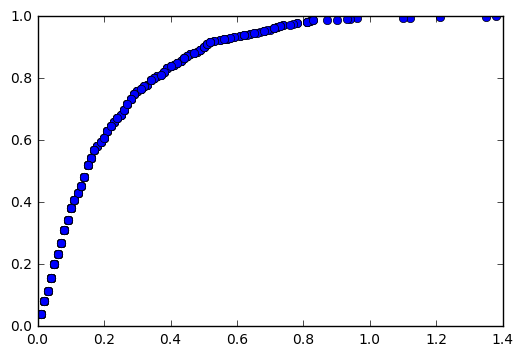

In [35]:
from statsmodels.distributions.empirical_distribution import ECDF

Fhat = ECDF(nerve_firings)

plt.plot(nerve_firings, Fhat(nerve_firings), 'o')
plt.show()

Now let us plot a $95\%$ confidence envelope around this function using the Dvorecky-Kiefer-Wolfowitz inequality:

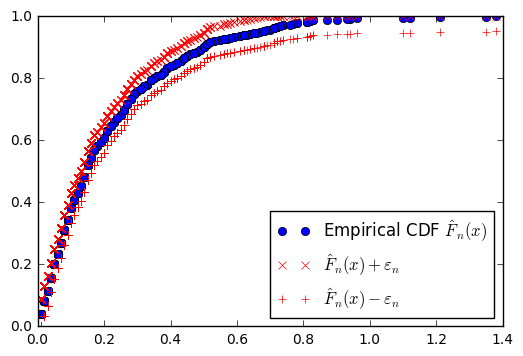

In [63]:
alpha = 0.05
epsilon_n = np.sqrt(np.log(2/alpha)/(2*len(nerve_firings.index)))

plt.plot(nerve_firings, Fhat(nerve_firings), 'bo', label = r'Empirical CDF $\hat{F}_n(x)$' )
plt.plot(nerve_firings, np.minimum(Fhat(nerve_firings) + epsilon_n,1), 'rx', label = r'$\hat{F}_n(x)+\varepsilon_n$')
plt.plot(nerve_firings, np.maximum(Fhat(nerve_firings) - epsilon_n,0), 'r+', label = r'$\hat{F}_n(x)-\varepsilon_n$')

plt.legend(loc = 4)

plt.show()

We can use $\hat{F}_n$ to estimate probabilities of intervals:

$$\mathrm{P}\left(\textrm{Waiting time }\in [0.6,0.4]\right)=F(0.6)-F(0.4)\approx\hat{F}_n(0.6)-\hat{F}_n(0.4)=0.093$$

as:

In [64]:
Fhat(0.6)-Fhat(0.4)

0.092615769712140139

# Bootstrap confidence interval for the skewness

The plug-in estimate of the skewness of a distribution is given by

$$\hat\theta = \frac{\frac{1}{n}\sum_{i=1}^n(X_i-\bar X_n)^3}{\hat{\sigma}^3}$$

This quantity measures the degree of asymmetry of a distribution. This is computed by the *.skew()* method of a DataFrame:


In [67]:
nerve_firings.skew()

1.7645629694054865

Here we want to illustrate the bootstrap procedure by estimating the variance of $\hat\theta$. 

In [91]:
N = len(nerve_firings.index) #Number of real samples
B = 1000 #Number of bootstrap samples

theta_boot = []

for i in range(B):
    # Since nerve_firings is a Series, we can index its rows as nerve_firings[ ]
    theta_boot.append(pd.Series([nerve_firings[np.random.randint(0,N)] for j in range(N)]).skew())
theta_boot = np.array(theta_boot)

And thus the bootstrap standard error is:

In [92]:
theta_boot.std()

0.1685412953700032

This allow us to conclude that $1.76\pm 2\cdot 0.16$ is a $95% normal based confidence interval. To get the percentile interval, let us look at:

In [95]:
[np.percentile(theta_boot,0.025, interpolation='higher'), np.percentile(theta_boot, 0.975)]

[1.2865146119462394, 1.3542426555448799]